In [1]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

from sklearn.model_selection import KFold

from textblob import TextBlob
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict


from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import RandomizedSearchCV

Populating the interactive namespace from numpy and matplotlib


# Rating Learning and Prediction for Amazon Product Reviews

## Bahman Roostaei

$\textit{December 2016, Galvanize , San Fransisco.} $

In this project we use the reviews of various products submitted by Amazon.com customers to understand the models that can best predict (classify) the ratings. The data are obtained from [here](http://www.cs.jhu.edu/~mdredze/datasets/sentiment/). We first use classification models and calculate the accuracy score and present the confusion matrix. Since this is a multiclass classification we group the ratings that are close to each other (4 and 5) and (1,2). Note that there is no (3) option (see below for the histogram of labels). We then use regressor models to be able to analyze the model by ROC curve.

### Part 1. Data.  

Data have been provided as dictionary of joined tokens (bag of bi-grams) for each review. Here we reprocess the data and convert them to a document with the same structure as reflected in dictionaries with the corresponding number of times it is repeated. 

In [2]:
class review_analysis(object):
    # This class reads and process the reviews.
    
    def __init__(self,product_name,filename):
        # instanciate the class by giving the product name or the filename in which
        # the train and test files are.
        self.product_name = product_name
        self.filename = filename
        
    def read(self):
        
        # read the Amazon processed files.
        
        with open(self.product_name+'/'+self.filename) as f:
            self._data = f.readlines()
    
        
    
    def process(self,pure_token = False):
         
        # if pure_token = True returns a list of single strings each containing all the 
        # tokens (no underscores) repeated in the same number as original review 
        # but stop words removed.
        # In all cases it returns the labels as well.
        
        self._pure_token = pure_token
        data = self._data
        X = [] # X is list of dictionaries (or processed reviewes) in the selected product name.
            
        y = [] # y corresponds to the labels.
        
        for rev in data: 
            rev_dict = defaultdict(int)
            for W in rev.split()[:-1:]:
                key= W.split(':')[0]
                value = int(W.split(':')[1]) 
                rev_dict[key] = value
                
            X.append(rev_dict)
            label = rev.split()[-1].split(':')[1]
            y.append(float(label))
    
        if pure_token:
            stop_words = stopwords.words('English')
            review_nostop = []
            for review in X:
                tokens = []
                for key,value in review.items():
                    key_split = key.split('_')
                    for elem in key_split:
                        if elem not in stop_words:
                            for _ in range(value):
                                tokens.append(elem)
                review_nostop.append(' '.join(tokens))
    
            return review_nostop,y
        else:
            return X,y

We start with the book review and their star ratings:

In [40]:
rva = review_analysis('dvd','train')
rva.read()
X,y = rva.process(pure_token=False)

In [41]:
reviews = []
for review in X:
    rev = []
    for key,value in review.items():
        for i in range(value):
            rev.append(key)
    rev_joined = ' '.join(rev)
    reviews.append(rev_joined)

Here is a sample of the review generated after processing. The double tokens are not in the human meaningful order.

In [5]:
reviews[0]

"to vu fast_moving fast actors_exciting excellent_acting moving_action it of top_story reality moving selection story_line deja and_selection action top partly_sci-fi line to_own excellent casting own casting_and own_it today's acting_great selection_of sci-fi_partly partly partly reality_life action_can't biting line_partly exciting blu-ray life_excellent great_casting can't_wait today's_reality nail_biting can't biting_fast life in_blu-ray it_in wait_to story partly_today's nail actors of_actors exciting_nail wait deja_vu sci-fi acting in great and"

In [42]:
# data copied to X.
X = reviews

Below we can observe that the ratings are balanced.

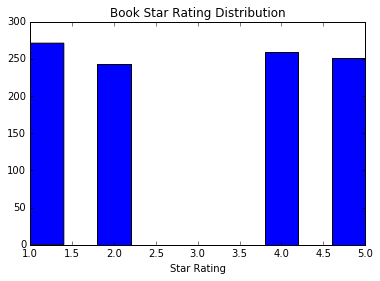

In [7]:
plt.hist(y)
plt.xlabel('Star Rating')
plt.title('Book Star Rating Distribution');

We also can analyze the polarity distribution of the documents and investigate how they are related to the ratings. We use TextBlob:

In [8]:
polarity = []
for i in range(len(y)):
    blob = TextBlob(X[i])
    polarity.append(blob.polarity)

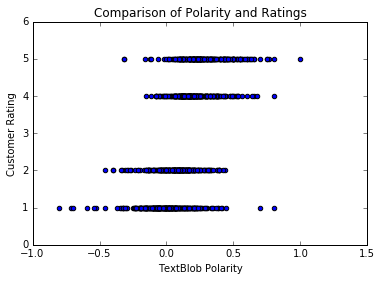

In [9]:
plt.scatter(polarity,y)
plt.xlabel('TextBlob Polarity')
plt.ylabel('Customer Rating')
plt.title('Comparison of Polarity and Ratings');

From the above we observe that the extreme ratings (1,5) cover wider range of polarities.

### Part 2. Classifiers:

We use count vectorizing. Note that Tf-idf vectorizing did not improve in any significant order our results that is why we don't present them here. The reason for this is that in understanding the sentiment of a document perhaps certain words (or bi-grams) play the most important way of recognizing the mood of the text.

In [43]:
vectorizer = CountVectorizer(min_df=1)
vec_train = vectorizer.fit_transform(X)

In [44]:
# Here we process the separate test file:
rva_test = review_analysis('dvd','test')
rva_test.read()
X_test,y_test_original = rva_test.process(pure_token=False)

In [45]:
reviews = []
for review in X_test:
    rev = []
    for key,value in review.items():
        for i in range(value):
            rev.append(key)
    rev_joined = ' '.join(rev)
    reviews.append(rev_joined)
X_test = reviews   

In [46]:
# vectorizing the test file:
vec_test_original = vectorizer.transform(X_test)

In [47]:
# This dictionary shows the accuracy for each model.
results_count = defaultdict(float)

In [48]:
kf = KFold(n_splits=5)

Multinomial Bayes is the first model we are going to examine. We use 5-fold split to find the mean accuracy score. Here we use cross-validation over training set. The important point is that we observe that the classifier is not able to very well classify the ratings that are close to each other by 1 unit. That is why we calculate the score by 1 unit of rating difference:

In [49]:
score = 0
for train_index,test_index in kf.split(vec_train):
    X_train, X_test = vec_train[train_index], vec_train[test_index]
    y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]
    mnb = MultinomialNB()
    mnb.fit(X_train,y_train)
    y_predict = mnb.predict(X_test)
    acc = [1 for i in range(len(y_predict)) if abs(y_predict[i]-y_test[i]) <= 1]
    score += sum(acc)/len(y_predict)
results_count['NB'] = score/5

In [50]:
results_count

defaultdict(float, {'NB': 0.74222859875657576})

In [52]:
threshold = 2
FP = 0
TP = 0
FN = 0
TN = 0
for i in range(len(y_predict)):
    if abs(y_predict[i] - y_test_original[i]) <= threshold and abs(y_predict[i]-5) <= threshold and abs(y_test_original[i]-1) <= threshold:
        FP += 1 
    if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-5) <= threshold and abs(y_test_original[i]-5) <= threshold:
        TP += 1 
    if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-1) <= threshold and abs(y_test_original[i]-5) <= threshold:
        FN += 1 
    if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-1) <= threshold and abs(y_test_original[i]-1) <= threshold:
        TN += 1            
FP = FP/len(y_predict)
TP = TP/len(y_predict)
FN = FN/len(y_predict)
TN = TN/len(y_predict)
print('Naive Bayes Confusion Matrix:')
print('TN=',TN,'--','FP=',FP)
print('FN=',FN,'--','TP=',TP)
print('F1 score:',2*TP/(2*TP+FP+FN))

Naive Bayes Confusion Matrix:
TN= 0.24509803921568626 -- FP= 0.07352941176470588
FN= 0.13725490196078433 -- TP= 0.2647058823529412
F1 score: 0.7152317880794702


We start the Random Forest and Gradient Boosting classification with default parameters and later on we use randomized grid search to find the best score:

In [53]:
rfc = RandomForestClassifier()
rfc.fit(vec_train,y)
y_predict = rfc.predict(vec_test_original)
acc = [1 for i in range(len(y_predict)) if abs(y_predict[i]-y_test_original[i]) <= 1]
score = sum(acc)/len(y_predict)
results_count['RF'] = score

In [54]:
results_count

defaultdict(float, {'NB': 0.74222859875657576, 'RF': 0.64631167562286274})

In [55]:
threshold = 2
FP = 0
TP = 0
FN = 0
TN = 0
for i in range(len(y_predict)):
    if abs(y_predict[i] - y_test_original[i]) <= threshold and abs(y_predict[i]-5) <= threshold and abs(y_test_original[i]-1) <= threshold:
        FP += 1 
    if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-5) <= threshold and abs(y_test_original[i]-5) <= threshold:
        TP += 1 
    if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-1) <= threshold and abs(y_test_original[i]-5) <= threshold:
        FN += 1 
    if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-1) <= threshold and abs(y_test_original[i]-1) <= threshold:
        TN += 1            
FP = FP/len(y_predict)
TP = TP/len(y_predict)
FN = FN/len(y_predict)
TN = TN/len(y_predict)
print('Default Random Forest Confusion Matrix:')
print('TN=',TN,'--','FP=',FP)
print('FN=',FN,'--','TP=',TP)
print('F1 score:',2*TP/(2*TP+FP+FN))

Default Random Forest Confusion Matrix:
TN= 0.3539325842696629 -- FP= 0.03663898387884709
FN= 0.0537371763556424 -- TP= 0.2923790913531998
F1 score: 0.866136034732272


In [56]:
mnb = GradientBoostingClassifier()
mnb.fit(vec_train,y)
y_predict = mnb.predict(vec_test_original.toarray())
acc = [1 for i in range(len(y_predict)) if abs(y_predict[i]-y_test_original[i]) <= 1]
score = sum(acc)/len(y_predict)
results_count['GB'] = score

In [57]:
results_count

defaultdict(float,
            {'GB': 0.71543722520762087,
             'NB': 0.74222859875657576,
             'RF': 0.64631167562286274})

In [59]:
threshold = 2
FP = 0
TP = 0
FN = 0
TN = 0
for i in range(len(y_predict)):
    if abs(y_predict[i] - y_test_original[i]) <= threshold and abs(y_predict[i]-5) <= threshold and abs(y_test_original[i]-1) <= threshold:
        FP += 1 
    if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-5) <= threshold and abs(y_test_original[i]-5) <= threshold:
        TP += 1 
    if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-1) <= threshold and abs(y_test_original[i]-5) <= threshold:
        FN += 1 
    if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-1) <= threshold and abs(y_test_original[i]-1) <= threshold:
        TN += 1            
FP = FP/len(y_predict)
TP = TP/len(y_predict)
FN = FN/len(y_predict)
TN = TN/len(y_predict)
print('Default GBoost Confusion Matrix:')
print('TN=',TN,'--','FP=',FP)
print('FN=',FN,'--','TP=',TP)
print('F1 score:',2*TP/(2*TP+FP+FN))

Default GBoost Confusion Matrix:
TN= 0.3475818270639961 -- FP= 0.05202735710796287
FN= 0.036394723986321445 -- TP= 0.36785539814362483
F1 score: 0.892708950800237


The randomized grid search does a good job in finding the best classifier:

In [26]:
random_forest_grid = {'max_depth': [3, None],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_split': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [10, 20, 60],
                      'random_state': [1]}

rf_gridsearch = RandomizedSearchCV(RandomForestClassifier(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='accuracy')
rf_gridsearch.fit(vec_train,y)
print("best parameters:", rf_gridsearch.best_params_)
best_rf_model = rf_gridsearch.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.6min finished


best parameters: {'random_state': 1, 'max_depth': None, 'max_features': None, 'n_estimators': 60, 'bootstrap': True, 'min_samples_split': 4}


In [60]:
y_predict = best_rf_model.predict(vec_test_original)
acc = sum([1 for i in range(len(y_predict)) if abs(y_predict[i]-y_test_original[i]) <= 1])/len(y_predict)
print('Accuracy for best paramter for random forest:',acc)
results_count['RF_GridCV'] = score

Accuracy for best paramter for random forest: 0.707620908647


In [61]:
results_count

defaultdict(float,
            {'GB': 0.71543722520762087,
             'NB': 0.74222859875657576,
             'RF': 0.64631167562286274,
             'RF_GridCV': 0.71543722520762087})

In [62]:
threshold = 2
FP = 0
TP = 0
FN = 0
TN = 0
for i in range(len(y_predict)):
    if abs(y_predict[i] - y_test_original[i]) <= threshold and abs(y_predict[i]-5) <= threshold and abs(y_test_original[i]-1) <= threshold:
        FP += 1 
    if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-5) <= threshold and abs(y_test_original[i]-5) <= threshold:
        TP += 1 
    if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-1) <= threshold and abs(y_test_original[i]-5) <= threshold:
        FN += 1 
    if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-1) <= threshold and abs(y_test_original[i]-1) <= threshold:
        TN += 1            
FP = FP/len(y_predict)
TP = TP/len(y_predict)
FN = FN/len(y_predict)
TN = TN/len(y_predict)
print('Best Random Forest Confusion Matrix:')
print('TN=',TN,'--','FP=',FP)
print('FN=',FN,'--','TP=',TP)
print('F1 score:',2*TP/(2*TP+FP+FN))

Best Random Forest Confusion Matrix:
TN= 0.33048363458720076 -- FP= 0.058866634098680995
FN= 0.04127992183683439 -- TP= 0.3771372740595994
F1 score: 0.8827901658090338


### Part 3. Regressors:

In [30]:
rfc = RandomForestRegressor()
rfc.fit(vec_train,y)
y_predict = rfc.predict(vec_test_original)
acc = [1 for i in range(len(y_predict)) if abs(y_predict[i]-y_test_original[i]) <= 1]
score = sum(acc)/len(y_predict)
results_count['RF_Reg'] = score

In [31]:
results_count

defaultdict(float,
            {'GB': 0.71543722520762087,
             'NB': 0.74222859875657576,
             'RF': 0.63702979970688811,
             'RF_GridCV': 0.71543722520762087,
             'RF_Reg': 0.49218368343917929})

In [32]:
threshold_vals = np.linspace(-6,6,100)
FP_list = []
TP_list = []
for threshold in threshold_vals:
    #threshold = 2
    FP = 0
    for i in range(len(y_predict)):
        if abs(y_predict[i] - y_test_original[i]) <= threshold and abs(y_predict[i]-5) <= threshold and abs(y_test_original[i]-5) > threshold:
            FP += 1 
    FP = FP/len(y_predict)
    TP = 0
    for i in range(len(y_predict)):
        if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-5) <= threshold and abs(y_test_original[i]-5) <= threshold:
            TP += 1 
    TP = TP/len(y_predict)
    FP_list.append(FP)
    TP_list.append(TP)

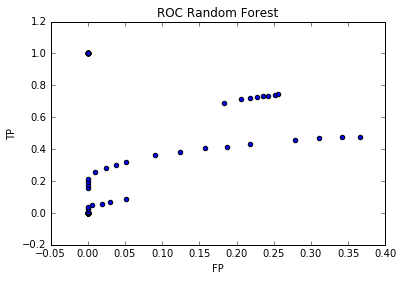

In [33]:
plt.scatter(FP_list,TP_list)
plt.xlabel('FP')
plt.ylabel('TP')
plt.title('ROC Random Forest');

Note here that ROC curve is not smoothly behaving since we are analyzing multiclass regression.

In [37]:
rfc = GradientBoostingRegressor()
rfc.fit(vec_train,y)
y_predict = rfc.predict(vec_test_original.toarray())
acc = [1 for i in range(len(y_predict)) if abs(y_predict[i]-y_test_original[i]) <= 1]
score = sum(acc)/len(y_predict)
results_count['GB_Reg'] = score

In [38]:
threshold_vals = np.linspace(-6,6,100)
FP_list = []
TP_list = []
for threshold in threshold_vals:
    #threshold = 2
    FP = 0
    for i in range(len(y_predict)):
        if abs(y_predict[i] - y_test_original[i]) <= threshold and abs(y_predict[i]-5) <= threshold and abs(y_test_original[i]-5) > threshold:
            FP += 1 
    FP = FP/len(y_predict)
    TP = 0
    for i in range(len(y_predict)):
        if abs(y_predict[i] - y_test_original[i]) <= threshold  and abs(y_predict[i]-5) <= threshold and abs(y_test_original[i]-5) <= threshold:
            TP += 1 
    TP = TP/len(y_predict)
    FP_list.append(FP)
    TP_list.append(TP)

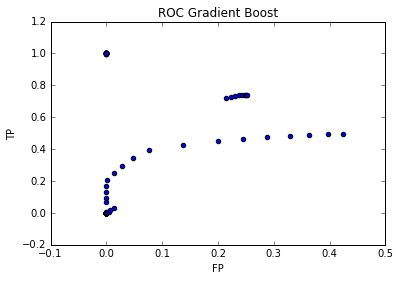

In [39]:
plt.scatter(FP_list,TP_list)
plt.xlabel('FP')
plt.ylabel('TP')
plt.title('ROC Gradient Boost');

### Conclusion

The Boosting and Random Forest classifiers do a great job classifying the ratings with bag of words methods and simple count vectorizing. The major reason for this is that the sentiment of a text is mostly recognized by certain words better than by any long sequence of words. This can be seen as we try to use bag of bi-grams which lowers the accuracy of the model.

It would be very interesting to analyze the review by clustering algorithms such topic modeling and perhaps Kmeans. Clustering will help to predict not only the sentiment of the review but also to specify the product name and by that making recommendation to the customer.